In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing

In [2]:
LABEL_COLOR_MAP = {
	0: 'b',
	1: 'g',
	2: 'r',
	3: 'c',
	4: 'm',
	5: 'y',
	6: 'k',
	7: 'b',
	8: 'g',
	9: 'r',
	10: 'c',
	11: 'm',
	12: 'y',
	13: 'k',
	14: 'b',
	15: 'g',
	16: 'r',
	17: 'c',
	18: 'm',
	19: 'y',
	20: 'k',
	21: 'b',
	22: 'g',
	23: 'r',
	24: 'c',
	25: 'm',
	26: 'y',
	27: 'k',
	28: 'b',
	29: 'g',
	30: 'r'
}

def train_and_get_stats(clf, X_train, Y_train, X_test, Y_test):
    start = time.time()
    clf.fit(X_train, Y_train)
    end = time.time()
    training_time = end - start
    
    start = time.time()
    train_acc = clf.score(X_train, Y_train)
    end = time.time()
    train_score_time = end - start
    
    start = time.time()
    test_acc = clf.score(X_test, Y_test)
    end = time.time()
    test_score_time = end - start
    
    cv_scores_train = cross_val_score(clf, X_train, Y_train, cv=5)
    cv_scores_test = cross_val_score(clf, X_test, Y_test, cv=5)
    
    return {
        'train_time': training_time,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_score_time': train_score_time,
        'test_score_time': test_score_time,
        'cv_scores_train': cv_scores_train,
        'cv_scores_test': cv_scores_test
    }


def plot_training_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, fig_size=(10, 10), train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure(figsize=fig_size)
    plt.title(title)
    if ylim is not None:
        plt.set_ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Test score")
    plt.legend(loc="best")
    

def plot_validation_curve(clf, param_name, param_range, X_train, Y_train, title='Validation Curve', cv=5, n_jobs=1):
    train_scores, test_scores = validation_curve(
        clf, 
        X_train, 
        Y_train, 
        param_name=param_name, 
        param_range=param_range, 
        cv=cv,
        n_jobs=n_jobs, 
        scoring = "accuracy"
    )

    plt.figure(figsize=(10, 10))
    plt.title(title, fontsize=20)
    plt.xlabel(param_name, fontsize=15)
    plt.ylabel("Score", fontsize=15)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Test score",
                 color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

In [3]:
data = pd.read_csv('data/adult.data')
test = pd.read_csv('data/adult.test')
data.dropna(inplace=True)
# get discrete class columns from data, and one hot encode
discrete_classes = ['workclass',
                    'education', 
                    'sex',
                    'marital-status',
                    'occupation',
                    'relationship', 
                    'native-country',
                    'race', 
                    'salary-class']

x_keys = set(data.keys()) - set(['salary-class']) & set(test.keys()) - set(['salary-class'])
y_keys = set(['salary-class'])

cont_keys = x_keys - set(discrete_classes)

X_train = data[x_keys]
X_test = test[x_keys]

Y_train = data[y_keys].to_numpy().ravel()
Y_test = test[y_keys].to_numpy().ravel()

print(x_keys)

{'race', 'fnlwgt', 'education', 'native-country', 'relationship', 'age', 'education-num', 'capital-gain', 'workclass', 'marital-status', 'hours-per-week', 'sex', 'capital-loss', 'occupation'}


In [4]:
data2 = pd.read_csv('data/UCI_Credit_Card.csv')
target_column = ['default.payment.next.month']
data2.dropna(inplace=True)

data2.loc[(data2.SEX == 1), 'SEX'] = 'male'
data2.loc[(data2.SEX == 2), 'SEX'] = 'female'

data2.drop(index=data2.index[data2['EDUCATION'] == 0], inplace=True)
data2.loc[(data2.EDUCATION == 1), 'EDUCATION'] = 'graduate school'
data2.loc[(data2.EDUCATION == 2), 'EDUCATION'] = 'university'
data2.loc[(data2.EDUCATION == 3), 'EDUCATION'] = 'high school'
data2.loc[(data2.EDUCATION == 4), 'EDUCATION'] = 'others'
data2.loc[(data2.EDUCATION == 5), 'EDUCATION'] = 'unknown'
data2.loc[(data2.EDUCATION == 6), 'EDUCATION'] = 'unknown'

data2.drop(index=data2.index[data2['MARRIAGE'] == 0], inplace=True)
data2.loc[(data2.MARRIAGE == 1), 'MARRIAGE'] = 'married'
data2.loc[(data2.MARRIAGE == 1), 'MARRIAGE'] = 'married'
data2.loc[(data2.MARRIAGE == 2), 'MARRIAGE'] = 'single'
data2.loc[(data2.MARRIAGE == 3), 'MARRIAGE'] = 'others'

data2.drop(columns=['ID'], inplace=True)

discerete_columns = [
    'SEX',
    'EDUCATION',
    'MARRIAGE'
]

x_keys2 = set(data2.keys()) - set(target_column) & set(data2.keys()) - set(target_column)
y_keys2 = set(target_column)

cont_keys2 = x_keys2 - set(discerete_columns)

first_split = data2.sample(frac=0.6,random_state=200)
second_split = data2.drop(first_split.index)

X_train2 = first_split[x_keys2]
Y_train2 = first_split[y_keys2].to_numpy().ravel()

X_test2 = second_split[x_keys2]
Y_test2 = second_split[y_keys2].to_numpy().ravel()

Index(['PAY_6', 'PAY_AMT3', 'BILL_AMT1', 'BILL_AMT6', 'PAY_AMT6', 'PAY_0',
       'LIMIT_BAL', 'PAY_AMT5', 'PAY_AMT1', 'PAY_4', 'PAY_AMT2', 'BILL_AMT5',
       'MARRIAGE', 'PAY_3', 'PAY_AMT4', 'PAY_5', 'EDUCATION', 'AGE', 'PAY_2',
       'BILL_AMT2', 'BILL_AMT4', 'BILL_AMT3', 'SEX'],
      dtype='object')

In [5]:
labeled_cols = ['sex', 'relationship', 'workclass', 'education', 'occupation', 'race', 'marital-status', 'native-country']

for col in labeled_cols:
    le = preprocessing.LabelEncoder()
    le.fit(X_train[col])
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    class_map = {i: le.inverse_transform([i])[0] for i in range(len(le.classes_))}
    print(f'Col {col}: \n {class_map}')
    
le = preprocessing.LabelEncoder()
le.fit(Y_train)
Y_train = le.transform(Y_train)
Y_test = le.transform(Y_test)

labeled_cols = ['MARRIAGE', 'SEX', 'EDUCATION']

for col in labeled_cols:
    le = preprocessing.LabelEncoder()
    le.fit(X_train2[col])
    X_train2[col] = le.transform(X_train2[col])
    X_test2[col] = le.transform(X_test2[col])
    class_map = {i: le.inverse_transform([i])[0] for i in range(len(le.classes_))}
#     print(f'Col {col}: \n {class_map}')
    


Col sex: 
 {0: ' Female', 1: ' Male'}
Col relationship: 
 {0: ' Husband', 1: ' Not-in-family', 2: ' Other-relative', 3: ' Own-child', 4: ' Unmarried', 5: ' Wife'}
Col workclass: 
 {0: ' ?', 1: ' Federal-gov', 2: ' Local-gov', 3: ' Never-worked', 4: ' Private', 5: ' Self-emp-inc', 6: ' Self-emp-not-inc', 7: ' State-gov', 8: ' Without-pay'}
Col education: 
 {0: ' 10th', 1: ' 11th', 2: ' 12th', 3: ' 1st-4th', 4: ' 5th-6th', 5: ' 7th-8th', 6: ' 9th', 7: ' Assoc-acdm', 8: ' Assoc-voc', 9: ' Bachelors', 10: ' Doctorate', 11: ' HS-grad', 12: ' Masters', 13: ' Preschool', 14: ' Prof-school', 15: ' Some-college'}
Col occupation: 
 {0: ' ?', 1: ' Adm-clerical', 2: ' Armed-Forces', 3: ' Craft-repair', 4: ' Exec-managerial', 5: ' Farming-fishing', 6: ' Handlers-cleaners', 7: ' Machine-op-inspct', 8: ' Other-service', 9: ' Priv-house-serv', 10: ' Prof-specialty', 11: ' Protective-serv', 12: ' Sales', 13: ' Tech-support', 14: ' Transport-moving'}
Col race: 
 {0: ' Amer-Indian-Eskimo', 1: ' Asian-Pac

/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [6]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FactorAnalysis

# Kmeans clustering

## Dataset 1

In [ ]:
kmean_1 = KMeans(n_clusters=2, random_state=0).fit(X_train)
centers = kmean_1.cluster_centers_
y_pred = kmean_1.predict(X_train)

In [ ]:
y_pred = ['b' if _ == 0 else 'r' for _ in y_pred]
# y_pred = ['b' if _ == 0 else 'r' for _ in Y_train]

In [ ]:
num_features = len(cont_keys)

for i in x_keys - cont_keys:
    for j in cont_keys:
        plt.figure(figsize=(20,20))
        plt.scatter(X_train[i], X_train[j], c=y_pred, alpha=0.4)
        plt.title(f'Feature {i}, Feature {j}')
        plt.plot()
        plt.savefig(f'images/kmeans/gt_ds1/fig_features_{i}_{j}.png')
#         plt.show()
        plt.close()

## Dataset 2

In [ ]:
kmean_2 = KMeans(n_clusters=2, random_state=0).fit(X_train2)
centers = kmean_2.cluster_centers_
y_pred2 = kmean_2.predict(X_train2)

num_features = len(cont_keys2)

plt.figure(figsize=(20,20))
plt.scatter(X_train2['MARRIAGE'], X_train2['BILL_AMT2'], c=y_pred2, alpha=0.4)
plt.scatter(kmean_2.cluster_centers_[:,0], kmean_2.cluster_centers_[:,1], c="r", alpha=1)
plt.title(f'Feature {i}, Feature {j}')
plt.plot()
plt.savefig(f'images/kmeans/gt_ds2/fig_features_{i}_{j}.png')
plt.show()
plt.close()

In [ ]:
y_pred2 = ['b' if _ == 0 else 'r' for _ in y_pred2]
# y_pred2 = ['b' if _ == 0 else 'r' for _ in Y_train2]

In [ ]:
num_features = len(cont_keys2)

for i in x_keys2 - cont_keys2:
    for j in cont_keys2:
        plt.figure(figsize=(20,20))
        plt.scatter(X_train2[i], X_train2[j], c=y_pred2, alpha=0.4)
        plt.title(f'Feature {i}, Feature {j}')
        plt.plot()
        plt.savefig(f'images/kmeans/gt_ds2/fig_features_{i}_{j}.png')
#         plt.show()
        plt.close()

# Expectation maximization

## Dataset 1

In [ ]:
gm = GaussianMixture(n_components=2, random_state=0).fit(X_train)
y_pred = gm.predict(X_train)

In [ ]:
y_pred = ['b' if _ == 0 else 'r' for _ in y_pred]

In [ ]:
num_features = len(cont_keys)

for i in x_keys - cont_keys:
    for j in cont_keys:
        plt.figure(figsize=(20,20))
        plt.scatter(X_train[i], X_train[j], c=y_pred, alpha=0.4)
        plt.title(f'Feature {i}, Feature {j}')
        plt.plot()
        plt.savefig(f'images/GaussianMixture/gm1/fig_features_{i}_{j}.png')
#         plt.show()
        plt.close()

## Dataset 2

In [ ]:
gm2 = GaussianMixture(n_components=2, random_state=0).fit(X_train2)
y_pred2 = gm2.predict(X_train2)

In [ ]:
kmean_2 = GaussianMixture(n_components=2, random_state=0).fit(X_train2[['MARRIAGE', 'BILL_AMT2']])
y_pred2 = kmean_2.predict(X_train2[['MARRIAGE', 'BILL_AMT2']])

num_features = len(cont_keys2)

plt.figure(figsize=(20,20))
plt.scatter(X_train2['MARRIAGE'], X_train2['BILL_AMT2'], c=y_pred2, alpha=0.4)
plt.title(f'Feature {i}, Feature {j}')
# plt.plot()
plt.savefig(f'images/kmeans/gt_ds2/fig_features_{i}_{j}.png')
plt.show()
plt.close()

In [ ]:
y_pred2 = ['b' if _ == 0 else 'r' for _ in y_pred2]

In [ ]:
num_features = len(cont_keys2)

for i in x_keys2 - cont_keys2:
    for j in cont_keys2:
        plt.figure(figsize=(20,20))
        plt.scatter(X_train2[i], X_train2[j], c=y_pred2, alpha=0.4)
        plt.title(f'Feature {i}, Feature {j}')
        plt.plot()
        plt.savefig(f'images/GaussianMixture/gm2/fig_features_{i}_{j}.png')
#         plt.show()
        plt.close()

# Principle component analysis

In [7]:
X_train = preprocessing.normalize(X_train, norm='l2')
X_test = preprocessing.normalize(X_test, norm='l2')
    
X_train2 = preprocessing.normalize(X_train2, norm='l2')
X_test2 = preprocessing.normalize(X_test2, norm='l2')

## Dataset 1

In [ ]:
pca = PCA(n_components=0.99, random_state=10)
pca.fit(X_train)
print(f'variance ratio ({pca.n_components_} components): {pca.explained_variance_ratio_}')

In [ ]:
for i in range(2, 13):
    pca = PCA(n_components=i, random_state=10)
    X_r = pca.fit_transform(X_train)
    X_r_test = pca.transform(X_test)
    print(f'explained variance ratio ({pca.n_components_} components): {pca.explained_variance_ratio_}')

    for j in range(pca.n_components_):
        plt.figure(figsize=(20,20))
        for k in range(j+1, pca.n_components_):
            plt.scatter(X_r[:, j], X_r[:, k], color=LABEL_COLOR_MAP[k], alpha=.5, label=f'features {j}, {k}')

        if not j == k:
            plt.legend()
#             plt.show()
            plt.savefig(f'images/pca/ds1/scatter/{i}_fig_features_{j}_{k}.png')
        plt.close()

In [ ]:
pca = PCA(n_components=0.99, random_state=10)
X_r = pca.fit_transform(X_train)
X_r_test = pca.transform(X_test)

kmean_1 = KMeans(n_clusters=2, random_state=0).fit(X_r)
centers = kmean_1.cluster_centers_
y_pred = kmean_1.predict(X_r)

y_pred = ['b' if _ == 0 else 'r' for _ in y_pred]
for i in range(pca.n_components_):
    for j in range(i+1, pca.n_components_):
        plt.figure(figsize=(10,10))
        plt.scatter(X_r[:, i], X_r[:, j], c=y_pred, alpha=0.4)
        plt.title(f'Feature {i}, Feature {j}')
        plt.plot()
        plt.savefig(f'images/pca/ds1/kmeans/fig_features_{i}_{j}.png')
#         plt.show()
        plt.close()

In [ ]:
from sklearn.metrics import mean_squared_error
tmp = pca.inverse_transform(X_r)#np.abs(pca.inverse_transform(X_r) - X_train)
mean_squared_error(tmp, X_train)

In [82]:
pca = PCA(n_components=2, random_state=10)
X_r = pca.fit_transform(X_train)
X_r_test = pca.transform(X_test)

nn_classifier = MLPClassifier(hidden_layer_sizes=(5, 5, 5), activation='relu', solver='adam', alpha=0.0001, random_state=1)
nn_stats_pca_ds1 = train_and_get_stats(nn_classifier, X_r, Y_train, X_r_test, Y_test)
print(nn_stats_pca_ds1)

X_r2 = np.hstack((X_r2, y_pred[..., None]))
X_r_test2 = np.hstack((X_r_test2, y_pred_test[..., None]))
nn_classifier = MLPClassifier(hidden_layer_sizes=(5, 5, 5), activation='relu', solver='adam', alpha=0.0001, random_state=1)
nn_stats_pca_kmeans_ds1 = train_and_get_stats(nn_classifier, X_r2, Y_train2, X_r_test2, Y_test2)
print(nn_stats_pca_kmeans_ds1)


{'train_time': 4.759083032608032, 'train_acc': 0.7918982832222597, 'test_acc': 0.7931330999324366, 'train_score_time': 0.008090019226074219, 'test_score_time': 0.004014015197753906, 'cv_scores_train': array([0.79348994, 0.79115479, 0.79207617, 0.7919226 , 0.79530098]), 'cv_scores_test': array([0.79582438, 0.79269042, 0.79054054, 0.79146192, 0.79637592])}
{'train_time': 2.582028865814209, 'train_acc': 0.7813352636561056, 'test_acc': 0.7741585233441911, 'train_score_time': 0.0038220882415771484, 'test_score_time': 0.002192974090576172, 'cv_scores_train': array([0.7814588 , 0.7814588 , 0.7811804 , 0.7811804 , 0.78139794]), 'cv_scores_test': array([0.77411273, 0.77411273, 0.77411273, 0.77443609, 0.77401838])}


## Dataset 2

In [ ]:
pca = PCA(n_components=0.99, random_state=10)
X_r2 = pca.fit_transform(X_train2)
X_r_test2 = pca.transform(X_test2)
print(f'explained variance ratio ({pca.n_components_} components): {pca.explained_variance_ratio_}')

In [ ]:
for i in range(2, 13):
    pca = PCA(n_components=i, random_state=10)
    X_r2 = pca.fit_transform(X_train2)
    X_r_test2 = pca.transform(X_test2)
    print(f'explained variance ratio ({pca.n_components_} components): {pca.explained_variance_ratio_}')

    for j in range(pca.n_components_):
        plt.figure(figsize=(20,20))
        for k in range(j+1, pca.n_components_):
            plt.scatter(X_r2[:, j], X_r2[:, k], color=LABEL_COLOR_MAP[k], alpha=.5, label=f'features {j}, {k}')
           
        if not j == k:
            plt.legend()
#             plt.show()
            plt.savefig(f'images/pca/ds2/scatter/{i}_fig_features_{i}_{j}.png')
        plt.close()

In [ ]:
pca = PCA(n_components=2, random_state=10)
X_r2 = pca.fit_transform(X_train2)
X_r_test2 = pca.transform(X_test2)

kmean_2 = KMeans(n_clusters=2, random_state=0).fit(X_r2)
centers = kmean_2.cluster_centers_
y_pred = kmean_2.predict(X_r2)

y_pred = ['b' if _ == 0 else 'r' for _ in y_pred]
for i in range(pca.n_components_):
    for j in range(i+1, pca.n_components_):
        plt.figure(figsize=(10,10))
        plt.scatter(X_r2[:, i], X_r2[:, j], c=y_pred, alpha=0.4)
        plt.title(f'Feature {i}, Feature {j}')
        plt.plot()
        plt.savefig(f'images/pca/ds2/kmeans/fig_features_{i}_{j}.png')
#         plt.show()
        plt.close()

In [ ]:
from sklearn.metrics import mean_squared_error
tmp = pca.inverse_transform(X_r2)
mean_squared_error(tmp, X_train2)

In [83]:
pca = PCA(n_components=2, random_state=10)
X_r2 = pca.fit_transform(X_train2)
X_r_test2 = pca.transform(X_test2)

kmean_2 = KMeans(n_clusters=2, random_state=0).fit(X_r2)
centers = kmean_2.cluster_centers_
y_pred = kmean_2.predict(X_r2)
y_pred_test = kmean_2.predict(X_r_test2)

nn_classifier = MLPClassifier(hidden_layer_sizes=(5, 5, 5), activation='relu', solver='adam', alpha=0.0001, random_state=1)
nn_stats_pca_ds2 = train_and_get_stats(nn_classifier, X_r2, Y_train2, X_r_test2, Y_test2)
print(nn_stats_pca_ds2)


X_r2 = np.hstack((X_r2, y_pred[..., None]))
X_r_test2 = np.hstack((X_r_test2, y_pred_test[..., None]))
nn_classifier = MLPClassifier(hidden_layer_sizes=(5, 5, 5), activation='relu', solver='adam', alpha=0.0001, random_state=1)
nn_stats_pca_kmeans_ds2 = train_and_get_stats(nn_classifier, X_r2, Y_train2, X_r_test2, Y_test2)
print(nn_stats_pca_kmeans_ds2)


{'train_time': 1.8772590160369873, 'train_acc': 0.7813352636561056, 'test_acc': 0.7741585233441911, 'train_score_time': 0.0042879581451416016, 'test_score_time': 0.0023729801177978516, 'cv_scores_train': array([0.7814588 , 0.7814588 , 0.7811804 , 0.7811804 , 0.78139794]), 'cv_scores_test': array([0.77411273, 0.77411273, 0.77411273, 0.77443609, 0.77401838])}
{'train_time': 2.6026759147644043, 'train_acc': 0.7813352636561056, 'test_acc': 0.7741585233441911, 'train_score_time': 0.003864288330078125, 'test_score_time': 0.002179861068725586, 'cv_scores_train': array([0.7814588 , 0.7814588 , 0.7811804 , 0.7811804 , 0.78139794]), 'cv_scores_test': array([0.77411273, 0.77411273, 0.77411273, 0.77443609, 0.77401838])}


# Independent component analysis

## Dataset 1

In [ ]:
for i in range(2, 13):
    ica = FastICA(n_components=i, random_state=10)
    X_r = ica.fit_transform(X_train)
    X_r_test = ica.transform(X_test)

    for j in range(i):
        plt.figure(figsize=(20,20))
        for k in range(j+1, i):
            plt.scatter(X_r[:, j], X_r[:, k], color=LABEL_COLOR_MAP[k], alpha=.5, label=f'features {j}, {k}')
        
        if not j == k:
            plt.legend()
#             plt.show()
            plt.savefig(f'images/ica/ds1/scatter/{i}_fig_features_{j}_{k}.png')
        plt.close()

In [ ]:
n_components = 2

ica = FastICA(n_components=n_components, random_state=10)
X_r = ica.fit_transform(X_train)
X_r_test = ica.transform(X_test)

kmean_1 = KMeans(n_clusters=2, random_state=0).fit(X_r)
centers = kmean_1.cluster_centers_
y_pred = kmean_1.predict(X_r)

y_pred = ['b' if _ == 0 else 'r' for _ in y_pred]
for i in range(n_components):
    for j in range(i+1, n_components):
        plt.figure(figsize=(10,10))
        plt.scatter(X_r[:, i], X_r[:, j], c=y_pred, alpha=0.4)
        plt.title(f'Feature {i}, Feature {j}')
        plt.plot()
        plt.savefig(f'images/ica/ds1/kmeans/fig_features_{i}_{j}.png')
#         plt.show()
        plt.close()

In [86]:
ica = FastICA(n_components=2, random_state=10)
X_r = ica.fit_transform(X_train)
X_r_test = ica.transform(X_test)

nn_classifier = MLPClassifier(hidden_layer_sizes=(50), activation='relu', solver='adam', alpha=0.0001, random_state=1)
nn_stats_ica_ds1 = train_and_get_stats(nn_classifier, X_r, Y_train, X_r_test, Y_test)
print(nn_stats_ica_ds1)

kmean_2 = KMeans(n_clusters=2, random_state=0).fit(X_r_test)
centers = kmean_2.cluster_centers_
y_pred = kmean_2.predict(X_r)
y_pred_test = kmean_2.predict(X_r_test)

X_r = np.hstack((X_r, y_pred[..., None]))
X_r_test = np.hstack((X_r_test, y_pred_test[..., None]))
nn_classifier = MLPClassifier(hidden_layer_sizes=(5, 5, 5), activation='relu', solver='adam', alpha=0.0001, random_state=1)
nn_stats_ica_kmeans_ds1 = train_and_get_stats(nn_classifier, X_r, Y_train, X_r_test, Y_test)
print(nn_stats_pca_kmeans_ds1)


{'train_time': 8.127223253250122, 'train_acc': 0.7918675716347778, 'test_acc': 0.7931330999324366, 'train_score_time': 0.019471168518066406, 'test_score_time': 0.010161876678466797, 'cv_scores_train': array([0.79302933, 0.79007985, 0.79176904, 0.7919226 , 0.79422604]), 'cv_scores_test': array([0.79582438, 0.79207617, 0.78931204, 0.79084767, 0.79453317])}
{'train_time': 2.582028865814209, 'train_acc': 0.7813352636561056, 'test_acc': 0.7741585233441911, 'train_score_time': 0.0038220882415771484, 'test_score_time': 0.002192974090576172, 'cv_scores_train': array([0.7814588 , 0.7814588 , 0.7811804 , 0.7811804 , 0.78139794]), 'cv_scores_test': array([0.77411273, 0.77411273, 0.77411273, 0.77443609, 0.77401838])}


## Dataset 2

In [ ]:
for i in range(2, 13):
    ica = FastICA(n_components=i, random_state=10)
    X_r = ica.fit_transform(X_train2)
    X_r_test = ica.transform(X_test2)

    for j in range(i):
        plt.figure(figsize=(20,20))
        for k in range(j+1, i):
            plt.scatter(X_r[:, j], X_r[:, k], color=LABEL_COLOR_MAP[k], alpha=.5, label=f'features {j}, {k}')
        
        if not j == k:
            plt.legend()
#             plt.show()
            plt.savefig(f'images/ica/ds2/scatter/{i}_fig_features_{j}_{k}.png')
        plt.close()

In [ ]:
n_components = 2

ica = FastICA(n_components=n_components, random_state=10)
X_r = ica.fit_transform(X_train2)
X_r_test = ica.transform(X_test2)

kmean_1 = KMeans(n_clusters=2, random_state=0).fit(X_r)
centers = kmean_1.cluster_centers_
y_pred = kmean_1.predict(X_r)

y_pred = ['b' if _ == 0 else 'r' for _ in y_pred]
for i in range(n_components):
    for j in range(i+1, n_components):
        plt.figure(figsize=(10,10))
        plt.scatter(X_r[:, i], X_r[:, j], c=y_pred, alpha=0.4)
        plt.title(f'Feature {i}, Feature {j}')
        plt.plot()
        plt.savefig(f'images/ica/ds2/kmeans/fig_features_{i}_{j}.png')
#         plt.show()
        plt.close()

In [87]:
ica = FastICA(n_components=2, random_state=10)
X_r2 = ica.fit_transform(X_train2)
X_r_test2 = ica.transform(X_test2)

nn_classifier = MLPClassifier(hidden_layer_sizes=(5), activation='relu', solver='adam', alpha=0.0001, random_state=1)
nn_stats_ica_ds2 = train_and_get_stats(nn_classifier, X_r2, Y_train2, X_r_test2, Y_test2)
print(nn_stats_ica_ds2)

kmean_2 = KMeans(n_clusters=2, random_state=0).fit(X_r2)
centers = kmean_2.cluster_centers_
y_pred = kmean_2.predict(X_r2)
y_pred_test = kmean_2.predict(X_r_test2)

X_r2 = np.hstack((X_r2, y_pred[..., None]))
X_r_test2 = np.hstack((X_r_test2, y_pred_test[..., None]))
nn_classifier = MLPClassifier(hidden_layer_sizes=(5), activation='relu', solver='adam', alpha=0.0001, random_state=1)
nn_stats_ica_kmeans_ds2 = train_and_get_stats(nn_classifier, X_r2, Y_train2, X_r_test2, Y_test2)
print(nn_stats_ica_kmeans_ds2)


{'train_time': 0.9895069599151611, 'train_acc': 0.7813352636561056, 'test_acc': 0.7741585233441911, 'train_score_time': 0.004335880279541016, 'test_score_time': 0.0019979476928710938, 'cv_scores_train': array([0.7814588 , 0.7814588 , 0.7811804 , 0.7811804 , 0.78139794]), 'cv_scores_test': array([0.77411273, 0.77411273, 0.77411273, 0.77443609, 0.77401838])}
{'train_time': 1.0514769554138184, 'train_acc': 0.7813352636561056, 'test_acc': 0.7741585233441911, 'train_score_time': 0.0025322437286376953, 'test_score_time': 0.0015158653259277344, 'cv_scores_train': array([0.7814588 , 0.7814588 , 0.7811804 , 0.7811804 , 0.78139794]), 'cv_scores_test': array([0.77411273, 0.77411273, 0.77411273, 0.77443609, 0.77401838])}


# Random projection analysis

## Dataset 1

In [ ]:
rpa = GaussianRandomProjection(n_components=5, random_state=10)
X_r = rpa.fit_transform(X_train)
X_r_test = rpa.transform(X_test)

In [ ]:
for i in range(2, 13):
    rpa = GaussianRandomProjection(n_components=2)
    X_r = rpa.fit_transform(X_train)
    X_r_test = rpa.transform(X_test)

    for j in range(i):
        plt.figure(figsize=(20,20))
        for k in range(j+1, i):
            plt.scatter(X_r[:, 0], X_r[:, 1], color=LABEL_COLOR_MAP[k], alpha=.5, label=f'features {j}, {k}')
        
            if not j == k:
                plt.legend()
        #             plt.show()
                plt.savefig(f'images/rca/ds1/scatter/{i}_fig_features_{j}_{k}.png')
            plt.close()

In [ ]:
n_components = 2

rpa = GaussianRandomProjection(n_components=n_components)
X_r = rpa.fit_transform(X_train)
X_r_test = rpa.transform(X_test)

kmean_1 = KMeans(n_clusters=2, random_state=0).fit(X_r)
centers = kmean_1.cluster_centers_
y_pred = kmean_1.predict(X_r)

y_pred = ['b' if _ == 0 else 'r' for _ in y_pred]
for i in range(n_components):
    for j in range(i+1, n_components):
        plt.figure(figsize=(10,10))
        plt.scatter(X_r[:, i], X_r[:, j], c=y_pred, alpha=0.4)
        plt.title(f'Feature {i}, Feature {j}')
        plt.plot()
        plt.savefig(f'images/rca/ds1/kmeans/fig_features_{i}_{j}.png')
#         plt.show()
        plt.close()

In [88]:
rpa = GaussianRandomProjection(n_components=2, random_state=10)
X_r = rpa.fit_transform(X_train)
X_r_test = rpa.transform(X_test)

nn_classifier = MLPClassifier(hidden_layer_sizes=(50), activation='relu', solver='adam', alpha=0.0001, random_state=1)
nn_stats_rpa_ds1 = train_and_get_stats(nn_classifier, X_r, Y_train, X_r_test, Y_test)
print(nn_stats_rpa_ds1)

kmean_2 = KMeans(n_clusters=2, random_state=0).fit(X_r)
centers = kmean_2.cluster_centers_
y_pred = kmean_2.predict(X_r)
y_pred_test = kmean_2.predict(X_r_test)

X_r = np.hstack((X_r, y_pred[..., None]))
X_r_test = np.hstack((X_r_test, y_pred_test[..., None]))
nn_classifier = MLPClassifier(hidden_layer_sizes=(50), activation='relu', solver='adam', alpha=0.0001, random_state=1)
nn_stats_rpa_kmeans_ds1 = train_and_get_stats(nn_classifier, X_r, Y_train, X_r_test, Y_test)
print(nn_stats_pca_kmeans_ds1)


{'train_time': 7.599787950515747, 'train_acc': 0.7894106446362212, 'test_acc': 0.7911676186966402, 'train_score_time': 0.022433996200561523, 'test_score_time': 0.024550199508666992, 'cv_scores_train': array([0.79287579, 0.78961916, 0.79084767, 0.79207617, 0.79361179]), 'cv_scores_test': array([0.79244704, 0.79207617, 0.78931204, 0.78624079, 0.79023342])}
{'train_time': 2.582028865814209, 'train_acc': 0.7813352636561056, 'test_acc': 0.7741585233441911, 'train_score_time': 0.0038220882415771484, 'test_score_time': 0.002192974090576172, 'cv_scores_train': array([0.7814588 , 0.7814588 , 0.7811804 , 0.7811804 , 0.78139794]), 'cv_scores_test': array([0.77411273, 0.77411273, 0.77411273, 0.77443609, 0.77401838])}


## Dataset 2

In [ ]:
rpa = GaussianRandomProjection(n_components=10, random_state=10)
X_r2 = rpa.fit_transform(X_train2)
X_r_test2 = rpa.transform(X_test2)

In [ ]:
for i in range(2, 13):
    rpa = GaussianRandomProjection(n_components=i, random_state=10)
    X_r2 = rpa.fit_transform(X_train2)
    X_r_test2 = rpa.transform(X_test2)

    for j in range(i):
        plt.figure(figsize=(20,20))
        for k in range(j+1, i):
            plt.scatter(X_r2[:, j], X_r2[:, k], color=LABEL_COLOR_MAP[k], alpha=.5, label=f'features {j}, {k}')
        
        if not j == k:
            plt.legend()
#             plt.show()
            plt.savefig(f'images/rca/ds2/scatter/{i}_fig_features_{j}_{k}.png')
        plt.close()

In [ ]:
n_components = 2

rpa = GaussianRandomProjection(n_components=n_components, random_state=10)
X_r = rpa.fit_transform(X_train2)
X_r_test = rpa.transform(X_test2)

kmean_1 = KMeans(n_clusters=2, random_state=0).fit(X_r)
centers = kmean_1.cluster_centers_
y_pred = kmean_1.predict(X_r)

y_pred = ['b' if _ == 0 else 'r' for _ in y_pred]
for i in range(n_components):
    for j in range(i+1, n_components):
        plt.figure(figsize=(10,10))
        plt.scatter(X_r[:, i], X_r[:, j], c=y_pred, alpha=0.4)
        plt.title(f'Feature {i}, Feature {j}')
#         plt.plot()
        plt.savefig(f'images/rca/ds2/kmeans/fig_features_{i}_{j}.png')
        plt.show()
        plt.close()

In [89]:
rpa = GaussianRandomProjection(n_components=2, random_state=10)
X_r2 = rpa.fit_transform(X_train2)
X_r_test2 = rpa.transform(X_test2)

nn_classifier = MLPClassifier(hidden_layer_sizes=(1), activation='relu', solver='adam', alpha=0.0001, random_state=1)
nn_stats_rpa_ds2 = train_and_get_stats(nn_classifier, X_r2, Y_train2, X_r_test2, Y_test2)
print(nn_stats_rpa_ds2)

kmean_2 = KMeans(n_clusters=2, random_state=0).fit(X_r2)
centers = kmean_2.cluster_centers_
y_pred = kmean_2.predict(X_r2)
y_pred_test = kmean_2.predict(X_r_test2)

X_r2 = np.hstack((X_r2, y_pred[..., None]))
X_r_test2 = np.hstack((X_r_test2, y_pred_test[..., None]))
nn_classifier = MLPClassifier(hidden_layer_sizes=(5), activation='relu', solver='adam', alpha=0.0001, random_state=1)
nn_stats_rpa_kmeans_ds2 = train_and_get_stats(nn_classifier, X_r2, Y_train2, X_r_test2, Y_test2)
print(nn_stats_rpa_kmeans_ds2)


{'train_time': 0.48073792457580566, 'train_acc': 0.7813352636561056, 'test_acc': 0.7741585233441911, 'train_score_time': 0.0016701221466064453, 'test_score_time': 0.001322031021118164, 'cv_scores_train': array([0.7814588 , 0.7814588 , 0.7811804 , 0.7811804 , 0.78139794]), 'cv_scores_test': array([0.77411273, 0.77411273, 0.77411273, 0.77443609, 0.77401838])}
{'train_time': 1.3732340335845947, 'train_acc': 0.7813352636561056, 'test_acc': 0.7741585233441911, 'train_score_time': 0.002507925033569336, 'test_score_time': 0.001493215560913086, 'cv_scores_train': array([0.7814588 , 0.7814588 , 0.7811804 , 0.7811804 , 0.78139794]), 'cv_scores_test': array([0.77411273, 0.77411273, 0.77411273, 0.77443609, 0.77401838])}


# Linear Discriminant Analysis

## Dataset 1

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
rpa = LinearDiscriminantAnalysis(n_components=1)
X_r2 = rpa.fit_transform(X_train, Y_train)

plt.figure(figsize=(20,20))
plt.scatter(X_r2, X_r2, color='b', alpha=.25, label=f'features {0}, {0}')
# plt.show()
plt.savefig(f'images/other/ds1/scatter/fig_features_{0}_{0}.png')
plt.close()

kmean_1 = KMeans(n_clusters=2, random_state=0).fit(X_r2)
y_pred = kmean_1.predict(X_r2)

y_pred = ['b' if _ == 0 else 'r' for _ in y_pred]
plt.figure(figsize=(10,10))
plt.scatter(X_r2, X_r2, c=y_pred, alpha=0.4)
plt.title(f'Feature {0}, Feature {0}')
plt.plot()
plt.savefig(f'images/other/ds1/kmeans/fig_features_{0}_{0}.png')
# plt.show()
plt.close()

In [90]:
rpa = LinearDiscriminantAnalysis(n_components=1)
X_r = rpa.fit_transform(X_train, Y_train)
X_r_test = rpa.transform(X_test)

nn_classifier = MLPClassifier(hidden_layer_sizes=(50), activation='relu', solver='adam', alpha=0.0001, random_state=1)
nn_stats_lda_ds1 = train_and_get_stats(nn_classifier, X_r, Y_train, X_r_test, Y_test)
print(nn_stats_lda_ds1)

kmean_2 = KMeans(n_clusters=2, random_state=0).fit(X_r)
centers = kmean_2.cluster_centers_
y_pred = kmean_2.predict(X_r)
y_pred_test = kmean_2.predict(X_r_test)


X_r = np.hstack((X_r, y_pred[..., None]))
X_r_test = np.hstack((X_r_test, y_pred_test[..., None]))
nn_classifier = MLPClassifier(hidden_layer_sizes=(50), activation='relu', solver='adam', alpha=0.0001, random_state=1)
nn_stats_lda_kmeans_ds1 = train_and_get_stats(nn_classifier, X_r, Y_train, X_r_test, Y_test)
print(nn_stats_pca_kmeans_ds1)


{'train_time': 6.557997941970825, 'train_acc': 0.7998525843800867, 'test_acc': 0.7971254836926479, 'train_score_time': 0.018159151077270508, 'test_score_time': 0.009395360946655273, 'cv_scores_train': array([0.79579303, 0.7972973 , 0.80359337, 0.7972973 , 0.80528256]), 'cv_scores_test': array([0.79889469, 0.80251843, 0.78531941, 0.80251843, 0.79637592])}
{'train_time': 2.582028865814209, 'train_acc': 0.7813352636561056, 'test_acc': 0.7741585233441911, 'train_score_time': 0.0038220882415771484, 'test_score_time': 0.002192974090576172, 'cv_scores_train': array([0.7814588 , 0.7814588 , 0.7811804 , 0.7811804 , 0.78139794]), 'cv_scores_test': array([0.77411273, 0.77411273, 0.77411273, 0.77443609, 0.77401838])}


## Dataset 2

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
rpa = LinearDiscriminantAnalysis(n_components=1)
X_r2 = rpa.fit_transform(X_train2, Y_train2)
X_r_test2 = rpa.transform(X_test2)

plt.figure(figsize=(20,20))
plt.scatter(X_r2, X_r2, color='b', alpha=.25, label=f'features {0}, {0}')
# plt.show()
plt.savefig(f'images/other/ds2/scatter/fig_features_{0}_{0}.png')
plt.close()

kmean_1 = KMeans(n_clusters=2, random_state=0).fit(X_r2)
y_pred = kmean_1.predict(X_r2)

y_pred = ['b' if _ == 0 else 'r' for _ in y_pred]
plt.figure(figsize=(10,10))
plt.scatter(X_r2, X_r2, c=y_pred, alpha=0.4)
plt.title(f'Feature {0}, Feature {0}')
plt.plot()
plt.savefig(f'images/other/ds2/kmeans/fig_features_{0}_{0}.png')
# plt.show()
plt.close()

In [91]:
rpa = LinearDiscriminantAnalysis(n_components=1)
X_r2 = rpa.fit_transform(X_train2, Y_train2)
X_r_test2 = rpa.transform(X_test2)

nn_classifier = MLPClassifier(hidden_layer_sizes=(1), activation='relu', solver='adam', alpha=0.0001, random_state=1)
nn_stats_lda_ds2 = train_and_get_stats(nn_classifier, X_r2, Y_train2, X_r_test2, Y_test2)
print(nn_stats_lda_ds2)

kmean_2 = KMeans(n_clusters=2, random_state=0).fit(X_r2)
centers = kmean_2.cluster_centers_
y_pred = kmean_2.predict(X_r2)
y_pred_test = kmean_2.predict(X_r_test2)

X_r2 = np.hstack((X_r2, y_pred[..., None]))
X_r_test2 = np.hstack((X_r_test2, y_pred_test[..., None]))
nn_classifier = MLPClassifier(hidden_layer_sizes=(5), activation='relu', solver='adam', alpha=0.0001, random_state=1)
nn_stats_lda_kmeans_ds2 = train_and_get_stats(nn_classifier, X_r2, Y_train2, X_r_test2, Y_test2)
print(nn_stats_lda_kmeans_ds2)


{'train_time': 1.0587739944458008, 'train_acc': 0.7901887632941701, 'test_acc': 0.7844316378518333, 'train_score_time': 0.0028040409088134766, 'test_score_time': 0.001519918441772461, 'cv_scores_train': array([0.7814588 , 0.7814588 , 0.78674833, 0.7811804 , 0.78139794]), 'cv_scores_test': array([0.77411273, 0.77411273, 0.77411273, 0.77443609, 0.77401838])}
{'train_time': 1.1669797897338867, 'train_acc': 0.789687621805223, 'test_acc': 0.7835964252902363, 'train_score_time': 0.0028209686279296875, 'test_score_time': 0.001615762710571289, 'cv_scores_train': array([0.79175947, 0.79120267, 0.78619154, 0.78646993, 0.79197995]), 'cv_scores_test': array([0.78496868, 0.78789144, 0.78997912, 0.78362573, 0.78070175])}


# Neural Network stats

In [23]:
print(nn_stats_pca_ds1)
print(nn_stats_pca_ds2)

{'train_time': 3.6209380626678467, 'train_acc': 0.7918982832222597, 'test_acc': 0.7931330999324366, 'train_score_time': 0.011757850646972656, 'test_score_time': 0.0070819854736328125, 'cv_scores_train': array([0.79348994, 0.79115479, 0.79207617, 0.7919226 , 0.79530098]), 'cv_scores_test': array([0.79582438, 0.79269042, 0.79054054, 0.79146192, 0.79637592])}
{'train_time': 1.9683339595794678, 'train_acc': 0.7813352636561056, 'test_acc': 0.7741585233441911, 'train_score_time': 0.004770040512084961, 'test_score_time': 0.0023527145385742188, 'cv_scores_train': array([0.7814588 , 0.7814588 , 0.7811804 , 0.7811804 , 0.78139794]), 'cv_scores_test': array([0.77411273, 0.77411273, 0.77411273, 0.77443609, 0.77401838])}


In [24]:
print(nn_stats_ica_ds1)
print(nn_stats_ica_ds2)

{'train_time': 6.661478042602539, 'train_acc': 0.7918675716347778, 'test_acc': 0.7931330999324366, 'train_score_time': 0.02192211151123047, 'test_score_time': 0.01293182373046875, 'cv_scores_train': array([0.79302933, 0.79007985, 0.79176904, 0.7919226 , 0.79422604]), 'cv_scores_test': array([0.79582438, 0.79207617, 0.78931204, 0.79084767, 0.79453317])}
{'train_time': 6.661478042602539, 'train_acc': 0.7918675716347778, 'test_acc': 0.7931330999324366, 'train_score_time': 0.02192211151123047, 'test_score_time': 0.01293182373046875, 'cv_scores_train': array([0.79302933, 0.79007985, 0.79176904, 0.7919226 , 0.79422604]), 'cv_scores_test': array([0.79582438, 0.79207617, 0.78931204, 0.79084767, 0.79453317])}


In [26]:
print(nn_stats_rpa_ds1)
print(nn_stats_rpa_ds2)

{'train_time': 7.361087322235107, 'train_acc': 0.7894106446362212, 'test_acc': 0.7911676186966402, 'train_score_time': 0.020005226135253906, 'test_score_time': 0.010557889938354492, 'cv_scores_train': array([0.79287579, 0.78961916, 0.79084767, 0.79207617, 0.79361179]), 'cv_scores_test': array([0.79244704, 0.79207617, 0.78931204, 0.78624079, 0.79023342])}
{'train_time': 0.7304558753967285, 'train_acc': 0.7813352636561056, 'test_acc': 0.7741585233441911, 'train_score_time': 0.0017039775848388672, 'test_score_time': 0.0017499923706054688, 'cv_scores_train': array([0.7814588 , 0.7814588 , 0.7811804 , 0.7811804 , 0.78139794]), 'cv_scores_test': array([0.77411273, 0.77411273, 0.77411273, 0.77443609, 0.77401838])}


In [28]:
print(nn_stats_lda_ds1)
print(nn_stats_lda_ds1)

{'train_time': 7.267394065856934, 'train_acc': 0.7998525843800867, 'test_acc': 0.7971254836926479, 'train_score_time': 0.019817113876342773, 'test_score_time': 0.013002157211303711, 'cv_scores_train': array([0.79579303, 0.7972973 , 0.80359337, 0.7972973 , 0.80528256]), 'cv_scores_test': array([0.79889469, 0.80251843, 0.78531941, 0.80251843, 0.79637592])}
{'train_time': 7.267394065856934, 'train_acc': 0.7998525843800867, 'test_acc': 0.7971254836926479, 'train_score_time': 0.019817113876342773, 'test_score_time': 0.013002157211303711, 'cv_scores_train': array([0.79579303, 0.7972973 , 0.80359337, 0.7972973 , 0.80528256]), 'cv_scores_test': array([0.79889469, 0.80251843, 0.78531941, 0.80251843, 0.79637592])}


In [33]:
original_nn_states_ds1 = {'train_time': 8.596255540847778, 'train_acc': 0.8134578176345936, 'test_acc': 0.8146919722375775, 'train_score_time': 0.018999576568603516, 'test_score_time': 0.010000944137573242, 'cv_scores_train': np.array([0.79364348, 0.79299754, 0.70915233, 0.79806511, 0.78547297]), 'cv_scores_test': np.array([0.7979736 , 0.79422604, 0.24017199, 0.79514742, 0.78869779])}
original_nn_states_ds2 = {'train_time': 2.3473377227783203, 'train_acc': 0.7601759563450081, 'test_acc': 0.7450931262006181, 'train_score_time': 0.011999368667602539, 'test_score_time': 0.007999897003173828, 'cv_scores_train': np.array([0.73969933, 0.76169265, 0.7497216 , 0.6795657 , 0.76886661]), 'cv_scores_test': np.array([0.55574113, 0.71148225, 0.72818372, 0.58187135, 0.74686717])}

print(original_nn_states_ds1)
print(original_nn_states_ds2)


{'train_time': 8.596255540847778, 'train_acc': 0.8134578176345936, 'test_acc': 0.8146919722375775, 'train_score_time': 0.018999576568603516, 'test_score_time': 0.010000944137573242, 'cv_scores_train': array([0.79364348, 0.79299754, 0.70915233, 0.79806511, 0.78547297]), 'cv_scores_test': array([0.7979736 , 0.79422604, 0.24017199, 0.79514742, 0.78869779])}
{'train_time': 2.3473377227783203, 'train_acc': 0.7601759563450081, 'test_acc': 0.7450931262006181, 'train_score_time': 0.011999368667602539, 'test_score_time': 0.007999897003173828, 'cv_scores_train': array([0.73969933, 0.76169265, 0.7497216 , 0.6795657 , 0.76886661]), 'cv_scores_test': array([0.55574113, 0.71148225, 0.72818372, 0.58187135, 0.74686717])}


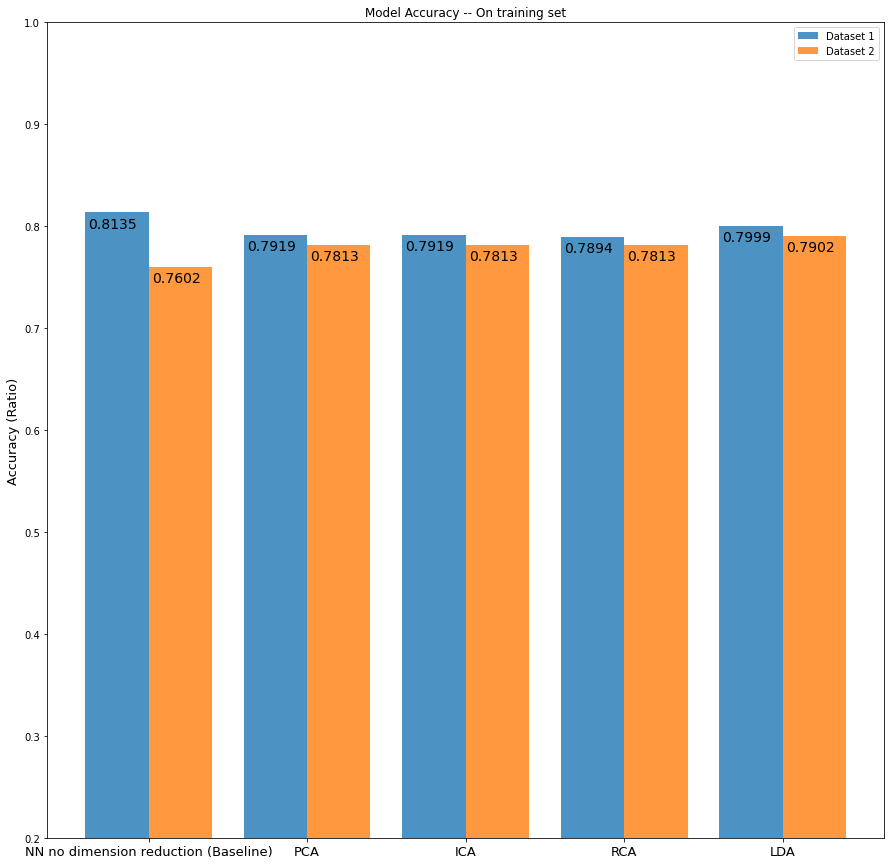

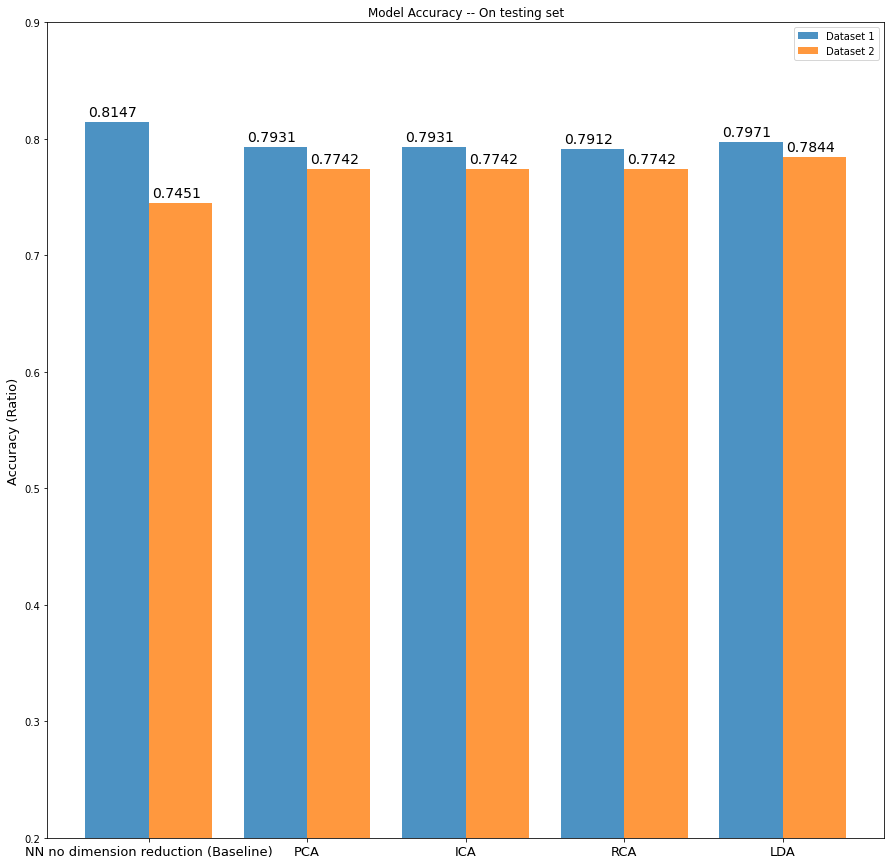

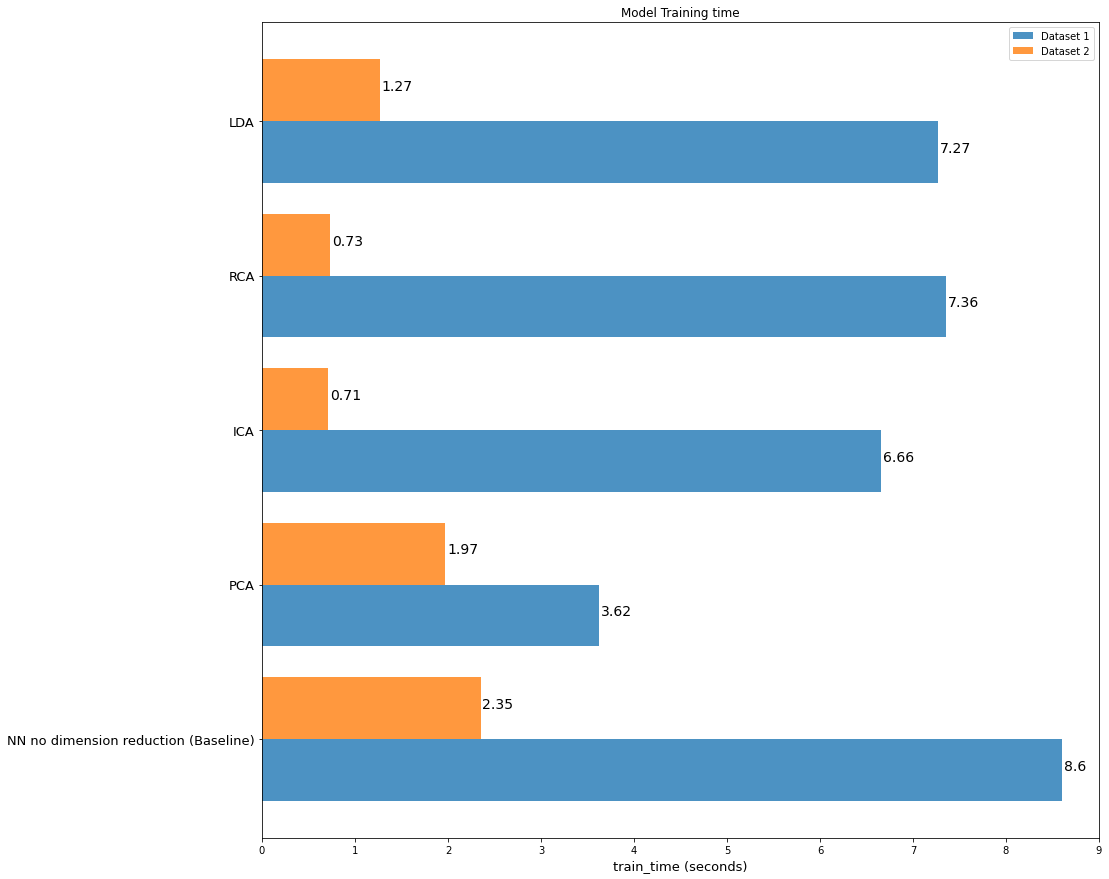

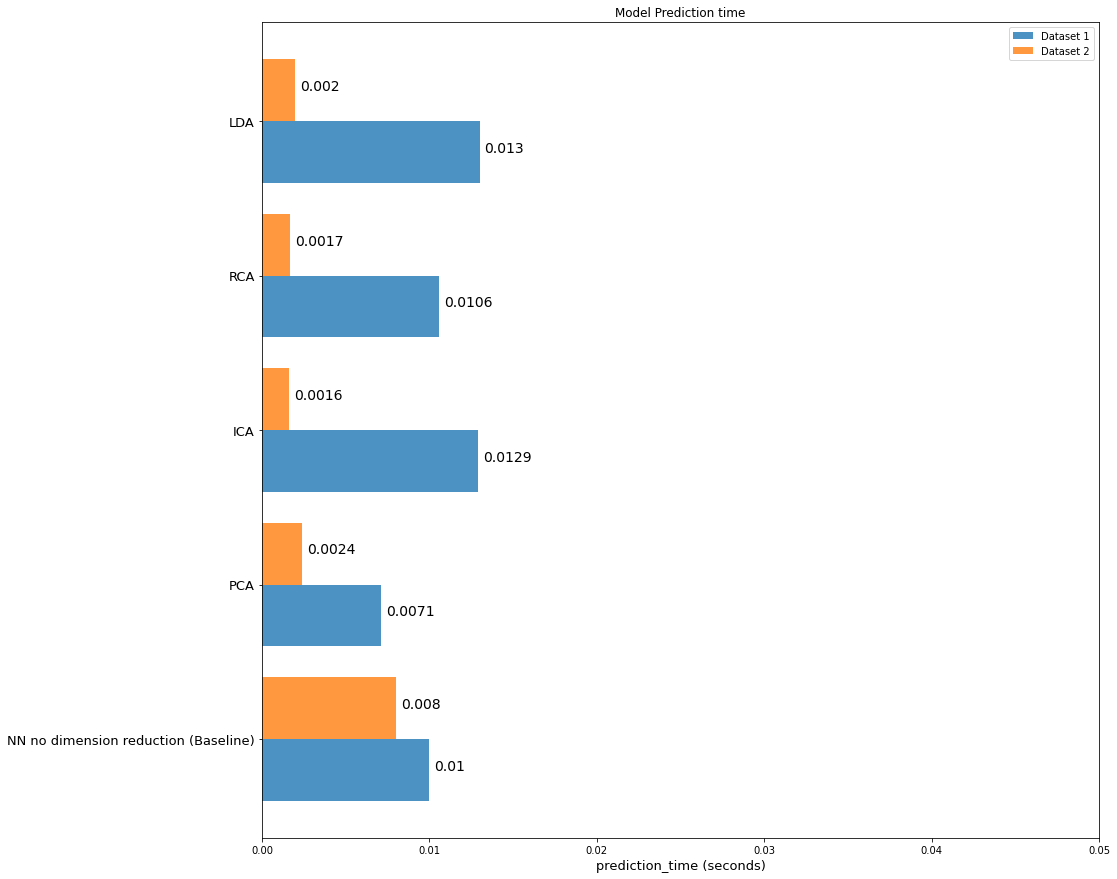

In [46]:
exp1 = [ 
    original_nn_states_ds1,
    nn_stats_pca_ds1,
    nn_stats_ica_ds1,
    nn_stats_rpa_ds1,
    nn_stats_lda_ds1
]
exp2 = [ 
    original_nn_states_ds2,
    nn_stats_pca_ds2,
    nn_stats_ica_ds2,
    nn_stats_rpa_ds2,
    nn_stats_lda_ds2
]

objects = ('NN no dimension reduction (Baseline)', 'PCA', 'ICA', 'RCA', 'LDA')
y_pos = np.arange(len(objects))

###########################################

performance_exp1 = []
performance_exp2 = []
for (item1, item2) in zip(exp1, exp2):
    performance_exp1.append(round(item1['train_acc'], 4))
    performance_exp2.append(round(item2['train_acc'], 4))
    
performance_exp1,

plt.figure(figsize=(15, 15))
plt.ylim(0.2, 1.0)
plt.bar(y_pos-0.2, performance_exp1, 0.4, align='center', alpha=0.8, label="Dataset 1")
plt.bar(y_pos+0.2, performance_exp2, 0.4, align='center', alpha=0.8, label="Dataset 2")
plt.legend()
plt.xticks(y_pos, objects, fontsize=13)
plt.ylabel('Accuracy (Ratio)', fontsize=13)
plt.title('Model Accuracy -- On training set')
for index, value in enumerate(zip(performance_exp1, performance_exp2)):
    plt.text(index-0.38, value[0]-0.015, str(value[0]), fontsize=14)
    plt.text(index+0.02, value[1]-0.015, str(value[1]), fontsize=14)
plt.show()

###########################################

performance_exp1 = []
performance_exp2 = []
for (item1, item2) in zip(exp1, exp2):
    performance_exp1.append(round(item1['test_acc'], 4))
    performance_exp2.append(round(item2['test_acc'], 4))

plt.figure(figsize=(15, 15))
plt.ylim(0.2, 0.9)
plt.bar(y_pos-0.2, performance_exp1, 0.4, align='center', alpha=0.8, label="Dataset 1")
plt.bar(y_pos+0.2, performance_exp2, 0.4, align='center', alpha=0.8, label="Dataset 2")
plt.legend()
plt.xticks(y_pos, objects, fontsize=13)
plt.ylabel('Accuracy (Ratio)', fontsize=13)
plt.title('Model Accuracy -- On testing set')
for index, value in enumerate(zip(performance_exp1, performance_exp2)):
    plt.text(index-0.38, value[0]+0.005, str(value[0]), fontsize=14)
    plt.text(index+0.02, value[1]+0.005, str(value[1]), fontsize=14)
plt.show()

###########################################

performance_exp1 = []
performance_exp2 = []
for (item1, item2) in zip(exp1, exp2):
    performance_exp1.append(round(item1['train_time'], 2))
    performance_exp2.append(round(item2['train_time'], 2))

plt.figure(figsize=(15, 15))
lim=9
plt.xlim(0, lim)
plt.barh(y_pos-0.2, performance_exp1, 0.4, align='center', alpha=0.8, label="Dataset 1")
plt.barh(y_pos+0.2, performance_exp2, 0.4, align='center', alpha=0.8, label="Dataset 2")
plt.legend()
plt.yticks(y_pos, objects, fontsize=13)
plt.xlabel('train_time (seconds)', fontsize=13)
plt.title('Model Training time')
for index, value in enumerate(zip(performance_exp1, performance_exp2)):
    plt.text(min(value[0], lim)+0.02, index-0.2, str(value[0]), fontsize=14)
    plt.text(min(value[1], lim)+0.02, index+0.2, str(value[1]), fontsize=14)
plt.show()

###########################################

performance_exp1 = []
performance_exp2 = []
for (item1, item2) in zip(exp1, exp2):
    performance_exp1.append(round(item1['test_score_time'], 4))
    performance_exp2.append(round(item2['test_score_time'], 4))

lim=0.05
plt.figure(figsize=(15, 15))
plt.xlim(0, lim)
plt.barh(y_pos-0.2, performance_exp1, 0.4, align='center', alpha=0.8, label="Dataset 1")
plt.barh(y_pos+0.2, performance_exp2, 0.4, align='center', alpha=0.8, label="Experiment 2")
plt.legend()
plt.yticks(y_pos, objects, fontsize=13)
plt.xlabel('prediction_time (seconds)', fontsize=13)
plt.title('Model Prediction time')
for index, value in enumerate(zip(performance_exp1, performance_exp2)):
    plt.text(min(value[0], lim)+0.0003, index-0.2, str(value[0]), fontsize=14)
    plt.text(min(value[1], lim)+0.0003, index+0.2, str(value[1]), fontsize=14)
plt.show()